### Training Deep Networks from Zero to Hero: avoiding pitfalls and going beyond
#### A Tutorial presented at SIBGRAPI 2021

**Moacir Antonelli Ponti**, Fernando Pereira dos Santos, Leo Sampaio Ferraz Ribeiro, Gabriel Biscaro Cavallari

Paper (extended version): https://arxiv.org/abs/2109.02752

## Part 1 - How to Start

### Notebook 2 - **DNNs under Attack, overfitting and features visualization**
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10, cifar100

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('Dataset size: ', x_train.shape)

Dataset size:  (50000, 32, 32, 3)


In [2]:
# getting shape info
img_lin, img_col = x_train.shape[1], x_train.shape[2]
num_classes = len(np.unique(y_train))
print(x_train.shape)

# normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

labels_train = y_train
labels_test = y_test

# transform labels into categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# check if images are RGB or grayscale
if (len(x_train.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train.shape[3]

# reshapes array accordingly
if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], n_channels, img_lin, img_col)
    x_test = x_test.reshape(x_test.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train = x_train.reshape(x_train.shape[0], img_lin, img_col, n_channels)
    x_test = x_test.reshape(x_test.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

(50000, 32, 32, 3)
Shape:  (32, 32, 3)


### Attack class 2

In [3]:
## comment this to see the effect without attack
#class2_ind = np.where(labels_train==2)[0]
#for i in class2_ind:
#    x_train[i][1:3,1,0:2] = 1

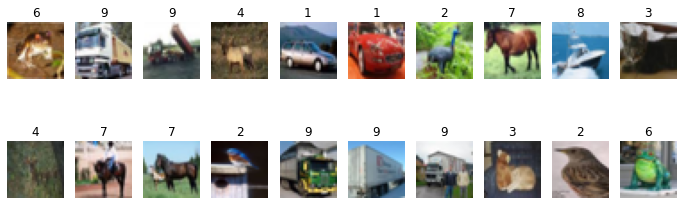

In [4]:
# visualizing images
fig, axes = plt.subplots(2,10, figsize=(12,4))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_train[i])
    ax[i].set_title("%d" % (labels_train[i]))
    ax[i].axis('off')

## Defining a validation set

In [5]:
# creating a validation set
val_set_size = int(len(x_train)*0.15)
print('Validation set size:', val_set_size)
x_val = x_train[-val_set_size:]
y_val = y_train[-val_set_size:]
label_val = labels_train[-val_set_size:]

# a subset of training set
subset_size = int(len(x_train)*0.25)
print('Training subset size:', subset_size)
x_sub = x_train[:subset_size]
y_sub = y_train[:subset_size]
label_sub = labels_train[:subset_size]

Validation set size: 7500
Training subset size: 12500


Let us build our own ResNet-inspired CNN

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import add

# my residual block
def residual_block(layer_in, n_filters=64):
    merge_input = layer_in

    # check if a first layer is needed to make the number of filters equal for addition
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)

    # sums input with conv2 output (skipping 2 layers)
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = keras.layers.Activation('relu')(layer_out)
    return layer_out
 

def my_resnet(input_shape, no_classes, no_filters=[32,64,64], no_blocks=3, dropout_rate=0.0, summary=False):
    if (len(no_filters) != no_blocks):
        print('Provide number of filters for each block')
        print('\ti.e. len(no_filters) == no_blocks')
        return None

    # define model input
    in_data = Input(shape=input_shape)
    x = residual_block(in_data, no_filters[0])
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)
    for i in range(1,no_blocks):
        x = residual_block(x, no_filters[i])
        x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    flatt = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    flatt_d = keras.layers.Dropout(dropout_rate)(flatt)
    softmax = keras.layers.Dense(no_classes, activation='softmax')(flatt_d)
    # create model
    ResNet = keras.models.Model(inputs=in_data, outputs=softmax)
    if summary: ResNet.summary()
    return ResNet

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

# larger model - will cause overfitting
# model = my_resnet(input_shape, no_classes=10, dropout_rate=0.1)

# slightly smaller model, increased dropout rate
model = my_resnet(input_shape, no_classes=10, no_filters=[32,32,64], dropout_rate=0.33)

In [8]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [9]:
batch_size = 32
epochs = 20
history = model.fit(x_sub, y_sub,
                    batch_size=batch_size,
                    epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Epoch 1/20
391/391 [==============================] - 71s 179ms/step - loss: 0.3223 - accuracy: 0.2118 - val_loss: 0.2723 - val_accuracy: 0.3345
Epoch 2/20
391/391 [==============================] - 69s 177ms/step - loss: 0.2675 - accuracy: 0.3484 - val_loss: 0.2450 - val_accuracy: 0.4056
Epoch 3/20
391/391 [==============================] - 69s 177ms/step - loss: 0.2460 - accuracy: 0.4168 - val_loss: 0.2225 - val_accuracy: 0.4845
Epoch 4/20
391/391 [==============================] - 69s 177ms/step - loss: 0.2290 - accuracy: 0.4669 - val_loss: 0.2102 - val_accuracy: 0.5111
Epoch 5/20
391/391 [==============================] - 69s 177ms/step - loss: 0.2161 - accuracy: 0.5110 - val_loss: 0.2016 - val_accuracy: 0.5431
Epoch 6/20
391/391 [==============================] - 69s 177ms/step - loss: 0.2056 - accuracy: 0.5415 - val_loss: 0.1918 - val_accuracy: 0.5743
Epoch 7/20
391/391 [==============================] - 69s 177ms/step - loss: 0.1976 - accuracy: 0.5653 - val_loss: 0.1898 - val_ac

In [10]:
score = model.evaluate(x_sub, y_sub, verbose=0)
print('Loss : ', score[0])
print('Accuracy : ', score[1])

Loss :  0.09949370473623276
Accuracy :  0.8172799944877625


In [11]:
scoreV = model.evaluate(x_val, y_val, verbose=0)
print('Validation')
print('Loss : ', scoreV[0])
print('Accuracy : ', scoreV[1])

Validation
Loss :  0.15692181885242462
Accuracy :  0.6733333468437195


Attacking the validation set

In [12]:
x_val_attack = x_val
for i in range(len(x_val_attack)):
    x_val_attack[i][1:3,1,0:2] = 1

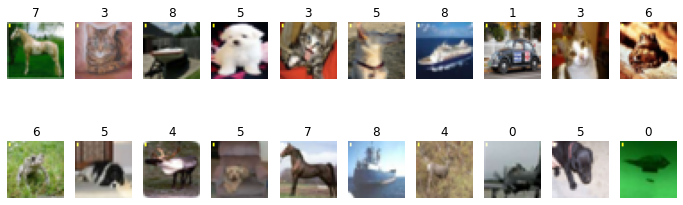

In [13]:
fig, axes = plt.subplots(2,10, figsize=(12,4))
ax = axes.ravel()
for i in range(20):
    ax[i].imshow(x_val_attack[i])
    ax[i].set_title("%d" % (label_val[i]))
    ax[i].axis('off')

In [14]:
scoreV = model.evaluate(x_val_attack, y_val, verbose=0)
print('Validation')
print('Loss : ', scoreV[0])
print('Accuracy : ', scoreV[1])

Validation
Loss :  0.15709228813648224
Accuracy :  0.6728000044822693


When under attack, the loss is **too high** and accuracy is almost **random**!

Let us look at the loss curve

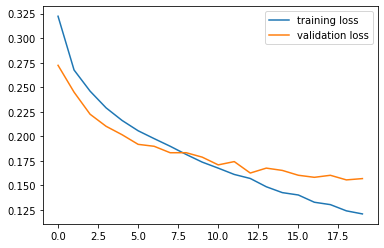

In [15]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

Look for signs of overfitting -- see validation loss diverges from training loss

Inspecting the features generated by the network is a possible way of detecting issues

In [16]:
# showing last 10 layers
for i, layer in zip(range(-10,0), model.layers[-10:]): 
    print(i, layer, layer.name)

-10 <keras.layers.pooling.MaxPooling2D object at 0x7efd362d8fd0> max_pooling2d_1
-9 <keras.layers.convolutional.Conv2D object at 0x7efd30ae0110> conv2d_6
-8 <keras.layers.convolutional.Conv2D object at 0x7efd30aed650> conv2d_7
-7 <keras.layers.convolutional.Conv2D object at 0x7efd30ae3810> conv2d_5
-6 <keras.layers.merge.Add object at 0x7efd30af37d0> add_2
-5 <keras.layers.core.Activation object at 0x7efd30af7710> activation_2
-4 <keras.layers.pooling.MaxPooling2D object at 0x7efd30aed110> max_pooling2d_2
-3 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7efd30afa590> avg_pool
-2 <keras.layers.core.Dropout object at 0x7efd30b01590> dropout
-1 <keras.layers.core.Dense object at 0x7efd30adb210> dense


In [17]:
# get the global average pooling layer
pool_output = model.get_layer('avg_pool').output
model_avgpool = keras.models.Model(model.inputs, pool_output)

features_train_avgpool = np.array(model_avgpool.predict(x_sub))
features_val_avgpool = np.array(model_avgpool.predict(x_val))

print('\tTraining features: ', features_train_avgpool.shape)
print('\tValidation features: ', features_val_avgpool.shape)

	Training features:  (12500, 64)
	Validation features:  (7500, 64)


In [18]:
# getting a subset for cleaner visualization
import random

def get_random_sample(data, label, n):
    random_indx = random.sample(range(len(data)), n)
    vis_sample = data[random_indx,:]
    vis_label = label[random_indx]
    return vis_sample, vis_label

vis_sample, vis_label = get_random_sample(features_train_avgpool, label_sub, 2000)

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
avgp_train_tsne = tsne.fit_transform(vis_sample)
print(avgp_train_tsne.shape)

(2000, 2)


In the case of an attack, note how a single class forms a cluster, while the remaining are quite overlapped

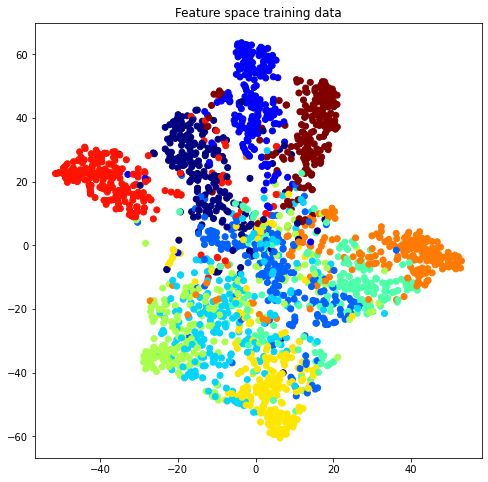

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(x = avgp_train_tsne[:,0], y=avgp_train_tsne[:,1], c=vis_label, cmap="jet")
plt.title('Feature space training data')
plt.show()

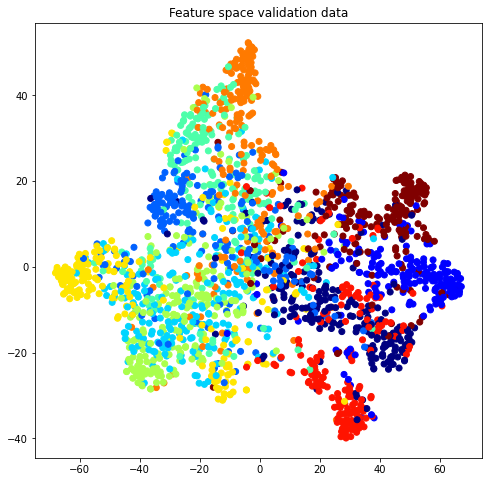

In [21]:
# now for the validation set
vis_sample_val, vis_label_val = get_random_sample(features_val_avgpool, label_val, 2000)

tsne = TSNE(n_components=2, random_state=0)
avgp_val_tsne = tsne.fit_transform(vis_sample_val)

plt.figure(figsize=(8, 8))
plt.scatter(x = avgp_val_tsne[:,0], y=avgp_val_tsne[:,1], c=vis_label_val, cmap="jet")
plt.title('Feature space validation data')
plt.show()

Inspecting a previous layer to confirm it

In [22]:
# get the penultimate residual block output after maxpooling
conv_output = model.layers[-8].output
print(model.layers[-8].name)

# to avoid high dimensionality let us create a new output pooling layer
feat_layer = keras.layers.GlobalAveragePooling2D()(conv_output)
model_conv = keras.models.Model(model.inputs, feat_layer)

features_train_conv = np.array(model_conv.predict(x_sub))
features_val_conv = np.array(model_conv.predict(x_val))

print('\tTraining features: ', features_train_conv.shape)
print('\tValidation features: ', features_val_conv.shape)

conv2d_7
	Training features:  (12500, 64)
	Validation features:  (7500, 64)


In [23]:
vis_sample_conv, vis_label = get_random_sample(features_train_conv, label_sub, 2000)

tsne = TSNE(n_components=2, random_state=0)
conv_train_tsne = tsne.fit_transform(vis_sample_conv)

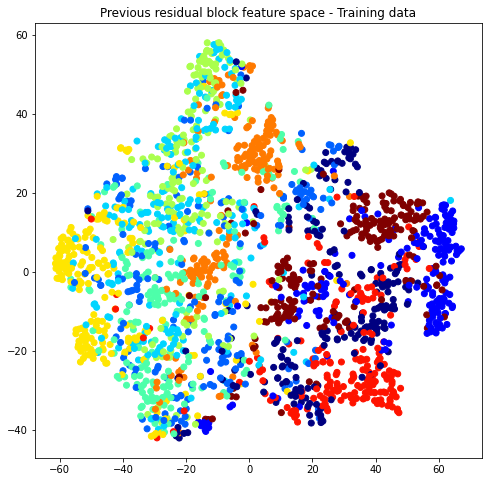

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(x = conv_train_tsne[:,0], y=conv_train_tsne[:,1], c=vis_label, cmap="jet")
plt.title('Previous residual block feature space - Training data')
plt.show()

#### External validation
- Using another dataset to obtain features would also create some clusters
- Let us use CIFAR 100 with coarse labels (20 classes), that are different from CIFAR 10 but images are from the same domain


In [25]:
(x_train2, y_train2), (x_test2, y_test2) = cifar100.load_data(label_mode="coarse")

print('Dataset size: ', x_train2.shape)
# getting shape info
img_lin, img_col = x_train2.shape[1], x_train2.shape[2]
num_classes = len(np.unique(y_train2))

# normalizing
x_train2 = x_train2.astype('float32') / 255.0
x_test2 = x_test2.astype('float32') / 255.0

labels_train2 = y_train2
labels_test2 = y_test2

# transform labels into categorical
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_test2 = keras.utils.to_categorical(y_test2, num_classes)

# check if images are RGB or grayscale
if (len(x_train2.shape) == 3):
      n_channels = 1
else:
      n_channels = x_train2.shape[3]

# reshapes array accordingly
if keras.backend.image_data_format() == 'channels_first':
    x_train2 = x_train2.reshape(x_train2.shape[0], n_channels, img_lin, img_col)
    x_test2 = x_test2.reshape(x_test2.shape[0], n_channels, img_lin, img_col)
    input_shape = (n_channels, img_lin, img_col)
else:
    x_train2 = x_train2.reshape(x_train2.shape[0], img_lin, img_col, n_channels)
    x_test2 = x_test2.reshape(x_test2.shape[0], img_lin, img_col, n_channels)
    input_shape = (img_lin, img_col, n_channels)

print("Shape: ", input_shape)

# a subset of training set
subset_size2 = int(len(x_train2)*0.25)
print('Training subset size:', subset_size2)
x_sub2 = x_train2[:subset_size2]
y_sub2 = y_train2[:subset_size2]
label_sub2 = labels_train2[:subset_size2]
print('\tlabel shape:', label_sub2.shape)

# a subset for validation
val_size2 = int(len(x_train2)*0.15)
print('Validation subset size:', val_size2)
x_val2 = x_train2[-val_size2:]
y_val2 = y_train2[-val_size2:]
label_val2 = labels_train2[-val_size2:]
print('\tlabel shape:', label_val2.shape)

Dataset size:  (50000, 32, 32, 3)
Shape:  (32, 32, 3)
Training subset size: 12500
	label shape: (12500, 1)
Validation subset size: 7500
	label shape: (7500, 1)


	Training features new data:  (12500, 64)
	Validation features new data:  (7500, 64)


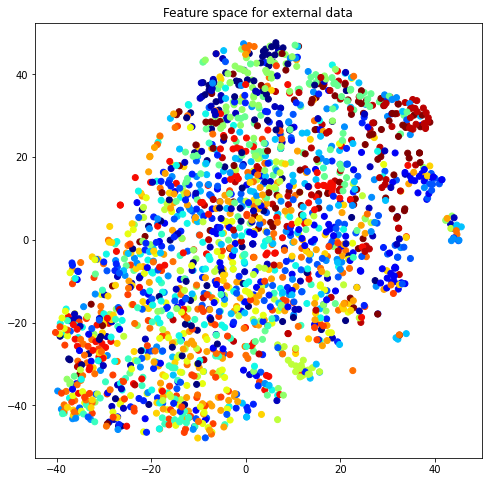

In [26]:
features_train2_avgpool = np.array(model_avgpool.predict(x_sub2))
features_val2_avgpool = np.array(model_avgpool.predict(x_val2))
print('\tTraining features new data: ', features_train_avgpool.shape)
print('\tValidation features new data: ', features_val2_avgpool.shape)

# random selection of 2k instances for cleaner visualization
vis_sample_ext, vis_label_ext = get_random_sample(features_train2_avgpool, label_sub2, 2000)

tsne = TSNE(n_components=2, random_state=0)
avgp_ext_tsne = tsne.fit_transform(vis_sample_ext)

plt.figure(figsize=(8, 8))
plt.scatter(x = avgp_ext_tsne[:,0], y=avgp_ext_tsne[:,1], c=vis_label_ext, cmap="jet")
plt.title('Feature space for external data')
plt.show()

Testing the features using an external classifier as proxy for linear separability of the feature space

In [27]:
from sklearn.svm import SVC, LinearSVC

svm_feats = LinearSVC(C=0.5)
svm_feats.fit(features_train2_avgpool, label_sub2.reshape(len(label_sub2)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [28]:
# evaluating on validation
print('Validation SVM Score: ', svm_feats.score(features_val2_avgpool, label_val2.reshape(len(label_val2))))

Validation SVM Score:  0.2833333333333333
